# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline

!wget https://covid.ourworldindata.org/data/owid-covid-data.csv
# import wandb

--2021-04-30 08:42:09--  https://covid.ourworldindata.org/data/owid-covid-data.csv
Resolving covid.ourworldindata.org (covid.ourworldindata.org)... 104.21.233.138, 104.21.233.137, 2606:4700:3038::6815:e98a, ...
Connecting to covid.ourworldindata.org (covid.ourworldindata.org)|104.21.233.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘owid-covid-data.csv’

owid-covid-data.csv     [ <=>                ]  20.99M  --.-KB/s    in 0.1s    

2021-04-30 08:42:09 (171 MB/s) - ‘owid-covid-data.csv’ saved [22014714]



# Utils

In [ ]:
def compare(dataframe, fields):
    fig, ax = plt.subplots(figsize=(10,10))
    for f in fields:
        ax.plot(dataframe["Date"], dataframe[f], label=f)
    ax.legend(loc="best")

In [ ]:
def mobility_check(df, where, what, everything=False, save=False):
    fig, ax = plt.subplots(figsize=(10,10))
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    ax.plot(df[df["District"]==where]["Date"], sc.fit_transform(df[df["State"]==where]["new cases"].to_numpy().reshape(-1, 1)), label=f"Cases @ {where}")
    sc = StandardScaler()
    ll = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline',]
    if everything:
        for l in ll:
            ax.plot(df[df["District"]==where]["Date"], sc.fit_transform(df[df["State"]==where][l].to_numpy().reshape(-1, 1)), label=l)
    else:
        ax.plot(df[df["District"]==where]["Date"], sc.fit_transform(df[df["State"]==where][what].to_numpy().reshape(-1, 1)), label=what)
    ax.legend(loc="best")
    if save:
        plt.savefig(f"{where},{what if not everything else ''}.png")

# Data Collection and Analysis

In [ ]:
df = pd.read_csv("district_mobility_cases.csv")
df["Date"]=pd.to_datetime(df["Date"])
df.info()
df.columns = ['District', 'Date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'State', 'new cases']

# df['new cases'].dtype == float

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181658 entries, 0 to 181657
Data columns (total 10 columns):
 #   Column                                              Non-Null Count   Dtype         
---  ------                                              --------------   -----         
 0   District                                            181658 non-null  object        
 1   Date                                                181658 non-null  datetime64[ns]
 2   retail_and_recreation_percent_change_from_baseline  167731 non-null  float64       
 3   grocery_and_pharmacy_percent_change_from_baseline   154821 non-null  float64       
 4   parks_percent_change_from_baseline                  169506 non-null  float64       
 5   transit_stations_percent_change_from_baseline       173456 non-null  float64       
 6   workplaces_percent_change_from_baseline             180672 non-null  float64       
 7   residential_percent_change_from_baseline            172356 non-null  float64       

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import keras

def smooth_plot(data, ax=None, *args, **kwargs):
    data = smoothen_data(data)
    if ax is None:
        plt.plot(data, *args, **kwargs)
    else:
        ax.plot(data, *args, **kwargs)
    
def smoothen_data(data):
    return savgol_filter(data, 51, 3)

def smoothen_df(df: pd.DataFrame, cols=None):
    if cols is None:
        cols = [i for i in df.columns if df[i].dtype==float]
        
    for i in cols:
        df[i] = smoothen_data(df[i])
        
    return df
    

colstoplot = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'new cases']

mumbai = df[df['District']=='Mumbai']
scaler = MinMaxScaler()
scaled_mumbai = mumbai.copy()

scaled_mumbai[colstoplot] =  scaler.fit_transform(scaled_mumbai[colstoplot])

scaled_mumbai['Date'] = pd.to_datetime(scaled_mumbai['Date'])
scaled_mumbai["Date"] = scaled_mumbai["Date"].dt.year * 30 * 12 + scaled_mumbai["Date"].dt.month * 30 + scaled_mumbai["Date"].dt.day
scaled_mumbai["Date"] -= scaled_mumbai["Date"].min()

fig, ax = plt.subplots(figsize=(10,10))
for col in (colstoplot):
    smooth_plot(scaled_mumbai[col].tolist(), ax=ax, label=col)
ax.legend()
# smooth_plot()


NameError: ignored

In [ ]:
df = pd.read_csv("/content/owid-covid-data.csv")
# df.info()
df_relevant = df[['location','new_cases','date','stringency_index']]
df_relevant['date'] = pd.to_datetime(df_relevant['date'])
# df_relevant
# df.info()
mobility = pd.read_csv("changes-visitors-covid.csv")
mobility.columns = ['location' if x=='Entity' else x for x in mobility.columns]
mobility.columns = ['date' if x=='Day' else x for x in mobility.columns]
mobility['date'] = pd.to_datetime(mobility['date'])
mobility = mobility.dropna()

# mobility.info()
# mobility

df_relevant = pd.merge(mobility, df_relevant, on=['date','location']).dropna()
print(df_relevant.columns)
df_relevant.info()

Index(['location', 'Code', 'date', 'retail_and_recreation',
       'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks',
       'workplaces', 'new_cases', 'stringency_index'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50571 entries, 0 to 51977
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   location               50571 non-null  object        
 1   Code                   50571 non-null  object        
 2   date                   50571 non-null  datetime64[ns]
 3   retail_and_recreation  50571 non-null  float64       
 4   grocery_and_pharmacy   50571 non-null  float64       
 5   residential            50571 non-null  float64       
 6   transit_stations       50571 non-null  float64       
 7   parks                  50571 non-null  float64       
 8   workplaces             50571 non-null  float64       
 9   new_cases              50

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# df_relevant.drop('Code',axis=1, inplace=True)
df_relevant

,location,date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,new_cases,stringency_index
0,Afghanistan,2020-02-24,1.000,6.286,0.286,6.143,2.714,6.000,1.0,8.33
1,Afghanistan,2020-02-25,0.857,6.286,0.429,6.143,2.429,6.143,0.0,8.33
2,Afghanistan,2020-02-26,0.857,6.571,0.429,6.571,2.571,6.143,0.0,8.33
3,Afghanistan,2020-02-27,1.000,6.143,0.571,6.429,2.857,6.286,0.0,8.33
4,Afghanistan,2020-02-28,0.714,5.571,0.857,6.000,2.429,6.143,0.0,8.33
...,...,...,...,...,...,...,...,...,...,...
51973,Zimbabwe,2021-04-19,12.571,37.429,2.143,16.571,22.143,-0.286,108.0,51.85
51974,Zimbabwe,2021-04-20,12.857,38.286,2.000,17.857,22.857,0.429,16.0,51.85
51975,Zimbabwe,2021-04-21,13.571,39.143,2.000,19.286,23.286,1.000,105.0,51.85
51976,Zimbabwe,2021-04-22,14.000,39.857,2.000,20.000,23.857,1.429,38.0,51.85


# Algorithm Developement

In [ ]:
def sliding_window(data, seq_len, j=0):
    samples = 0

    xs = []
    ys = []
    for i in range(0,len(data)-seq_len-1-j,seq_len+1+j):
        x = data[i:(i+seq_len)].drop(["date"], axis=1).to_numpy()
        y = data[(i+seq_len):i+seq_len+1+j]["new_cases"].to_numpy().flatten()#[0]
        xs.append(x)
        ys.append(y)
        samples += 1

  
    return np.array(xs, dtype=np.float64), np.array(ys, dtype=np.float64), samples

#### India District

In [ ]:
from tqdm import tqdm_notebook

prev_days = 28
forecast_days = 14

df = df[df['new cases']>=0]

def create_dataset(df, prev_days, forecast_days):
    xtrain, ytrain, xtest, ytest, transforms, train_idx, test_idx = [], [], [], [], [], [], []
    running_train, running_test = 0, 0
    df = df.drop(['State', *colstoplot[:-1]], axis=1)
    print(df.columns)
    for district in tqdm_notebook(df['District'].unique()):
        district_df = df[df['District']==district].copy()
        scaler = StandardScaler()
#         district_df = district_df.copy()
        if district_df.shape[0]<200:
             continue
        district_df = smoothen_df(district_df.drop('District',axis=1))

#         district_df[colstoplot] =  scaler.fit_transform(district_df[colstoplot])
#         districts_df["new cases"] = 

        district_df['Date'] = pd.to_datetime(district_df['Date'])
        district_df["Date"] = district_df["Date"].dt.year * 30 * 12 + district_df["Date"].dt.month * 30 + district_df["Date"].dt.day
        district_df["Date"] -= district_df["Date"].min()
        

        
        
#         district_df = district_df.drop('District',axis=1)

        # df_custom = smoothen_df(df_custom)
#         print(district_df)

        X, y = sliding_window(district_df[district_df['Date']<=250], prev_days, forecast_days-1)
        xt, yt = sliding_window(district_df[district_df['Date']>250], prev_days, forecast_days-1)
#         print(X.shape, y.shape, xt.shape, yt.shape)
        if 0 in X.shape or 0 in y.shape or 0 in xt.shape or 0 in yt.shape:
            continue
        transforms.append(scaler)

        train_idx.append(running_train)
        test_idx.append(running_test)
            
        running_train += X.shape[0]
        running_test += xt.shape[0]

            
        xtrain.append(X)
        ytrain.append(y)
        xtest.append(xt)
        ytest.append(yt)
        
        
    xtrain, ytrain, xtest, ytest = np.vstack(xtrain), np.vstack(ytrain), np.vstack(xtest), np.vstack(ytest)
    scaler = StandardScaler()
#     print(xtrain.shape)
#     xtrain = scaler.fit_transform(xtrain[:,:,0])
    return xtrain, ytrain, xtest, ytest, scaler
    
    #, transforms, test_idx, train_idx
    
    
def create_metadataset(df, prev_days, forecast_days, params):
    xtrain, ytrain, xtest, ytest, = [], [], [], []
    running_train, running_test = 0, 0
#     df = df.drop(['State', *colstoplot[:-1]], axis=1)
    for district in tqdm_notebook(df['District'].unique()):
        district_df = df[df['District']==district].copy()
        if district_df.shape[0]<200:
            del params[district]
            continue
        district_df = district_df.drop('District',axis=1)


        district_df['Date'] = pd.to_datetime(district_df['Date'])
        district_df["Date"] = district_df["Date"].dt.year * 30 * 12 + district_df["Date"].dt.month * 30 + district_df["Date"].dt.day
        district_df["Date"] -= district_df["Date"].min()
        district_df[colstoplot[:-1]] = district_df[colstoplot[:-1]].shift(-7)
        district_df = district_df.dropna()#[['new cases','Date']]
#         print(district_df)
        X, y = sliding_window(district_df, prev_days, forecast_days-1)
#         xt, yt = sliding_window(district_df[district_df['Date']>250], prev_days, forecast_days-1)
        if 0 in X.shape or 0 in y.shape:# or 0 in xt.shape or 0 in yt.shape:
            del params[district]
            continue
            
        xtrain.append(X)
        ytrain.append(y)
#         xtest.append(xt)
#         ytest.append(yt)
        
    return np.asarray(xtrain), np.asarray(ytrain)#, np.asarray(xtest), np.asarray(ytest)

def region_wise_normalized_df(df):
    df = df.drop(['State'], axis=1)
    df = smoothen_df(df)#.drop('District',axis=1))
    params = {}
    for region in df['District'].unique():
        rows = df['District']==region#['new cases']
        # df.loc[df['District']==region,'new cases'] = (cases - cases.min()) / (cases.max() - cases.min())
        # params[region] = [cases.min(), cases.max()]
        # scaler = MinMaxScaler()
        # df.loc[rows, colstoplot] = scaler.fit_transform(df.loc[rows, colstoplot])
        # params[region] = scaler
        params[region] = ''
        
#     print(df)
        
    return df, params

# xtrain, ytrain, xtest, ytest, transforms, tri, tei = create_dataset(df.dropna(), 28, 14)
# xtrain, ytrain, xtest, ytest = create_metadataset(df.dropna(), 28, 14)
df_new, params = region_wise_normalized_df(df.dropna())
xtrain, ytrain = create_metadataset(df_new, 28, 14, params)

# ytrain = transform.transform(ytrain)
# xtest = transform.transform(xtest)
# ytest = transform.transform(ytest)

#### World Country

In [ ]:
from tqdm import tqdm_notebook

prev_days = 28
forecast_days = 14
df_relevant = df_relevant[df_relevant['new_cases']>=0] 
    
def create_metadataset(df, prev_days, forecast_days, params, cols, time_col):
    xtrain, ytrain, xtest, ytest, india = [], [], [], [], []
    running_train, running_test = 0, 0
#     df = df.drop(['State', *colstoplot[:-1]], axis=1)
    for district in tqdm_notebook(df['location'].unique()):
        district_df = df[df['location']==district].copy()
        if district_df.shape[0]<200:
            del params[district]
            continue
        district_df = district_df.drop('location',axis=1)


        district_df[time_col] = pd.to_datetime(district_df[time_col])
        district_df[time_col] = (district_df[time_col] - district_df[time_col].min()).astype('timedelta64[D]')
        # district_df[colstoplot[:-1]] = district_df[colstoplot[:-1]].shift(-7)
        district_df = district_df.dropna()[cols]
#         print(district_df)
        X, y, samples = sliding_window(district_df, prev_days, forecast_days-1)
#         xt, yt = sliding_window(district_df[district_df['Date']>250], prev_days, forecast_days-1)
        if 0 in X.shape or 0 in y.shape:# or 0 in xt.shape or 0 in yt.shape:
            del params[district]
            continue
        test_samples = int(samples*0.25)
        test_indices = np.random.random_integers(0,samples-1,test_samples).tolist()
        train_indices = [i for i in range(samples-1) if i not in test_indices]
        Xtrain, Ytrain = X[train_indices,:,:], y[train_indices,:]
        Xtest, Ytest = X[test_indices,:,:], y[test_indices,:]
        if district == 'India':
            india.extend([Xtrain, Ytrain, Xtest, Ytest])
        # else:
        xtrain.append(Xtrain)
        ytrain.append(Ytrain)
        xtest.append(Xtest)
        ytest.append(Ytest)
            
    return np.asarray(xtrain), np.asarray(ytrain), np.asarray(xtest), np.asarray(ytest), india

def region_wise_normalized_df(df):
    # df = df.drop(['State'], axis=1)
    # df = smoothen_df(df)#.drop('District',axis=1))
    params = {}
    for region in df['location'].unique():
        rows = df['location']==region#['new cases']
        # df.loc[df['District']==region,'new cases'] = (cases - cases.min()) / (cases.max() - cases.min())
        # params[region] = [cases.min(), cases.max()]
        # scaler = MinMaxScaler()
        # df.loc[rows, colstoplot] = scaler.fit_transform(df.loc[rows, colstoplot])
        # params[region] = scaler
        params[region] = ''
        
#     print(df)
        
    return df, params

# xtrain, ytrain, xtest, ytest, transforms, tri, tei = create_dataset(df.dropna(), 28, 14)
# xtrain, ytrain, xtest, ytest = create_metadataset(df.dropna(), 28, 14)
# cols = ['date', 'retail_and_recreation',
#        'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks',
#        'workplaces', 'stringency_index', 'new_cases']
cols = ['date', 'new_cases']
df_new, params = region_wise_normalized_df(df_relevant.dropna())
xtrain, ytrain, xtest, ytest, india = create_metadataset(df_new, 28, 14, params, cols, 'date')

# ytrain = transform.transform(ytrain)
# xtest = transform.transform(xtest)
# ytest = transform.transform(ytest)

In [ ]:
india[0].shape, india[1].shape, india[2].shape, india[3].shape

((7, 28, 8), (7, 14), (2, 28, 8), (2, 14))

In [ ]:
# wandb_run.finish()

In [ ]:
import random
import tensorflow as tf

def get_mini_dataset(batchSize, iters, num_regions, datasets, test=False, single=False):
    # Shots is assumed to be all
    
    xtrain, ytrain = datasets

    if single:
        regions = [0]
    else:
        regions = random.choices(list(range(xtrain.shape[0])), k=num_regions)
    
#     xtrain, ytrain = np.vstack(xtrain[[regions]]), np.vstack(ytrain[[regions]])
    
    
    if test:
        xtests, ytests, xtrains, ytrains = [], [], [], []
        xtrain, ytrain = xtrain[[regions]],ytrain[[regions]]
#         print(xtrain.shape)
#         print(ytrain.shape)
#         print(xtrain.shape, ytrain.shape)
        for i in range(num_regions):
            xtests.append(np.expand_dims(xtrain[i][-1,:,:],0))
            ytests.append(ytrain[i][-1,:])
            xtrains.append(xtrain[i][:-1,:,:])
            ytrains.append(ytrain[i][:-1,:])

#             xtest, ytest = xtrain[-1,:,:], ytrain[-1,:]
#             xtrain, ytrain = xtrain[:-1,:,:], ytrain[:-1,:]
        # print(xtests[0].shape)
        xtrain, ytrain, xtest, ytest = np.vstack(xtrains), np.vstack(ytrains), np.vstack(xtests), np.stack(ytests)

    else:
        xtrain, ytrain = np.vstack(xtrain[[regions]]), np.vstack(ytrain[[regions]])
#     xtrain, ytrain = np.vstack(xtrains), np.vstack(ytrains)
#     print(xtrain.shape, ytrain.shape)
    
    dataset = tf.data.Dataset.from_tensor_slices(
        (xtrain.astype(np.float32), ytrain.astype(np.float32))
    )
    dataset = dataset.shuffle(100).batch(batchSize).repeat(iters)
    if test:
        # print(xtrain.shape, xtest.shape, ytest.shape)

        # print(xtest.shape)
        return dataset, xtest, ytest, regions
    return dataset, regions
# print(np.vstack(xtrain[[0,4,5]]).shape)

# xtrain, ytrain = create_metadataset(df.dropna(), 28, 14)
# dataset, te, ti, regions = get_mini_dataset(32, 4, 20, (xtest, ytest), True)
# dataset, te, ti, regions = get_mini_dataset(32, 4, 20, (xtrain, ytrain), True)



In [ ]:
!pip install nbeats-keras wandb > /dev/null
import sklearn
sklearn.__version__

'0.22.2.post1'

#### Seq2Seq

In [ ]:
n_hidden = 100

features = 7

input_train = keras.Input(shape=(prev_days, features))
output_train = keras.Input(shape=(forecast_days, 1))

encoder_stack_h, encoder_last_h, encoder_last_c = keras.layers.LSTM(
 n_hidden, activation='tanh', dropout=0.2,
 return_sequences=True, return_state=True, recurrent_activation = 'sigmoid')(input_train)


In [ ]:
print(encoder_stack_h.shape, encoder_last_h.shape, encoder_last_c.shape)

(None, 28, 100) (None, 100) (None, 100)


In [ ]:
decoder = keras.layers.RepeatVector(output_train.shape[1])(encoder_last_h)
decoder = keras.layers.LSTM(n_hidden, activation='tanh', dropout=0.2,
                            return_state=False, return_sequences=True, recurrent_activation = 'sigmoid')(
    decoder, initial_state=[encoder_last_h, encoder_last_c])

print(decoder.shape)

(None, 14, 100)


In [ ]:
attention = keras.layers.dot([decoder, encoder_stack_h], axes=[2, 2])
attention = keras.layers.Activation('softmax')(attention)

context = keras.layers.dot([attention, encoder_stack_h], axes=[2,1])

decoder_combined_context = keras.layers.concatenate([context, decoder])

out = keras.layers.TimeDistributed(keras.layers.Dense(1, activation='exponential'))(decoder_combined_context)

model = keras.Model(inputs=input_train, outputs=out)
model.compile()
optimizer = keras.optimizers.SGD(lr=0.001, clipnorm=1)
theta = tf.nn.softplus(tf.Variable(1., trainable=True))

#### Meta Learning

In [ ]:
## NBeats

from nbeats_keras.model import NBeatsNet as NBeatsKeras
num_samples, time_steps, input_dim, output_dim, exo_dim = 50_000, 28, 1, 14, 0

backend = NBeatsKeras(input_dim=input_dim,exo_dim=exo_dim,
    backcast_length=time_steps, forecast_length=output_dim,
    stack_types=(NBeatsKeras.TREND_BLOCK, NBeatsKeras.SEASONALITY_BLOCK),
    nb_blocks_per_stack=2, thetas_dim=(4, 4), share_weights_in_stack=True,
    hidden_layer_units=128
)
# loss = negbinLoss()
import keras
# Definition of the objective function and the optimizer.
backend.compile()
optimizer = keras.optimizers.SGD(lr=0.001, clipnorm=1)
model = backend

In [ ]:

# scaler = StandardScaler()
# ytrain.shape
len(params)
import warnings
warnings.filterwarnings('ignore')
import wandb
wandb.init()

Iteration,145
training error,3105.74708
testing error,8205.78299
training MAE,2154.69711
testing MAE,5875.23551
training MAPE,23.20784
testing MAPE,17.047
_runtime,102
_timestamp,1619779723
_step,29


Iteration,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
training error,█▇▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
testing error,█▇▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
training MAE,█▇▇▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
testing MAE,█▇▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
training MAPE,█▇▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
testing MAPE,█▇▇▆▅▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇█
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


In [ ]:
from wandb.keras import WandbCallback
import sklearn
from sklearn.metrics import mean_absolute_error

# model.__call__ = model.predict

trainingA, trainingR, trainingE, trainingmape = [], [], [], []
testingA, testingR, testingE, testingmape = [], [], [], []

meta_iters = 500
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
regions = 50

for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # Temporarily save the weights from the model.
    old_vars = model.get_weights()
    # Get a sample from the full dataset.
    mini_dataset, _ = get_mini_dataset(inner_batch_size, inner_iters, regions, (xtrain, ytrain))
    
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = tf.squeeze(model.models['forecast'](images))
            # preds = tf.squeeze(model.models['forecast']([images[:,:,-1],images[:,:,:-1]]))
            loss = keras.losses.mean_squared_error(labels, preds)
            # loss = keras.losses.poisson(labels, preds)
            # loss = negbinNLLLoss(labels, preds, theta)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_vars = model.get_weights()
    # Perform SGD for the meta step.
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )
    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_vars)
    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies, r2s, errors, mapes = [], [], [], []
        idk_index = 0
        for dataset in ([xtrain,ytrain], [xtest,ytest]):
            # Sample a mini dataset from the full dataset.
            train_set, test_images, test_labels, regs = get_mini_dataset(inner_batch_size, inner_iters, regions, 
                                                                   (dataset[0], dataset[1]), True)
            old_vars = model.get_weights()
            # Train on the samples and get the resulting accuracies.
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = tf.squeeze(model.models['forecast'](images))
                    # preds = tf.squeeze(model.models['forecast']([images[:,:,-1],images[:,:,:-1]]))
                    loss = keras.losses.mean_squared_error(labels, preds)
                    # loss = keras.losses.poisson(labels, preds)
                    # loss = negbinNLLLoss(labels, preds, theta)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
                
#             print(test_images.shape)
            test_preds = model.predict(test_images).squeeze()
            # test_preds = model.predict([test_images[:,:,-1],test_images[:,:,:-1]]).squeeze()
            # forecasts[idk_index]['x'] = test_images[0,:,-1]
            # forecasts[idk_index]['y'] = test_preds[0]
            # forecasts[idk_index]['true'] = test_labels[0]
            
#             mean(square(y_true - y_pred), axis=-1)
            error = mean_absolute_error(test_labels, test_preds)
            errors.append(error)
            num_correct = np.sqrt(np.square(test_preds - test_labels).mean())
            # Reset the weights after getting the evaluation accuracies.
            r2 = r2_score(test_labels, test_preds)
            mapes.append(mape(test_labels, test_preds))
            r2s.append(r2)
            model.set_weights(old_vars)
            accuracies.append(num_correct)
            idk_index += 1
        trainingR.append(r2s[0])
        testingR.append(r2s[1])
        trainingA.append(accuracies[0])
        testingA.append(accuracies[1])
        trainingE.append(errors[0])
        testingE.append(errors[1])
        trainingmape.append(mapes[0])
        testingmape.append(mapes[1])

        wandb.log({'Iteration': meta_iter,
                   'training error': accuracies[0],
                   'testing error': accuracies[1], 
                   'training R2': r2s[0],
                   'testing R2': r2s[1],
                   'training MAE':errors[0],
                   'testing MAE':errors[1],
                   'training MAPE':mapes[0],
                   'testing MAPE':mapes[1]})
        # if meta_iter % 10 == 0:
        #     print(
        #         "batch %d / %d: trainE=%f testE=%f trainA=%f testA=%f" % (meta_iter, meta_iters, accuracies[0], accuracies[1], r2s[0], r2s[1])
        #     )

In [ ]:
# mean_absol
# test_labels.shape
# mean_absolute_percentage_error(test_labels, test_preds)
# multioutput

# def mean_absolu?te_percentage_error(y_true, y_pred): 
    # y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)
a = 0

def mape(test_labels, test_preds):
    a = 0.0
    for i in range(test_labels.shape[0]):

      # print(np.sum(test_labels[i]))

      if np.any(test_labels[i] == 0.0):
          continue
      else:
          b = np.mean(np.abs((test_labels[i] - test_preds[i]) / (test_labels[i]))) * 100
          # print(b)
          # print(np.sum(test_labels[i]), b)
          a+=b

    return a/test_labels.shape[0]

mape(test_labels, test_preds)

39.494750002487656

In [94]:
model.save("meta_nbeats_trend_seasonality_epochs_univariate=500.h5")
# from sklearn.metrics import mean_absolute_percentage_error

In [96]:
# def evaluate_india(india):
# model = NBeatsKeras.load("/content/meta_nbeats_trend_seasonality_epochs_univariate_stringency_mobility=500.h5")

old_vars = model.get_weights()
iter = 0
for dataset in ([india[0],india[1]], [india[2],india[3]]):

# Sample a mini dataset from the full dataset.
    dset = [(dataset[0],dataset[1])]
    # test_images = np.expand_dims(dataset[0][-1,:,:], 0)
    # test_labels = dataset[1][-1,:]
    # train_set, test_images, test_labels, regs = get_mini_dataset(inner_batch_size, inner_iters, regions, 
    #                                                         (dataset[0], dataset[1]), True, True)
    
    # Train on the samples and get the resulting accuracies.
    if iter == 0:
        # pass
        for images, labels in dset:
            with tf.GradientTape() as tape:
                preds = tf.squeeze(model.models['forecast'](images))
                # preds = tf.squeeze(model.models['forecast']([images[:,:,-1],images[:,:,:-1]]))
                loss = keras.losses.mean_squared_error(labels, preds)
                # loss = keras.losses.poisson(labels, preds)
                # loss = negbinNLLLoss(labels, preds, theta)
            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
#             print(test_images.shape)
    # test_preds = model.predict(test_images).squeeze()

    else:
        test_preds = model.predict(dataset[0]).squeeze()# model.predict([dataset[0][:,:,-1],dataset[0][:,:,:-1]]).squeeze()

        mae = mean_absolute_error(dataset[1], test_preds)
        rmse = np.sqrt(np.square(test_preds - dataset[1]).mean())
        # Reset the weights after getting the evaluation accuracies.
        r2 = r2_score(dataset[1], test_preds)
        mapev = mape(dataset[1], test_preds)

    # if iter == 0:
    #     print(f"Meta-Train R2 {r2} RMSE {rmse} MAE {error}")

    # else:
    iter += 1
print(f"Meta-Test R2 {r2} RMSE {rmse} MAE {mae} MAPE {mapev}")


# model.set_weights(old_vars)


          

# evaluate_india(india)

Meta-Test R2 -5.101037197463989 RMSE 6613.083679100575 MAE 5510.041155133928 MAPE 12.033231499685046


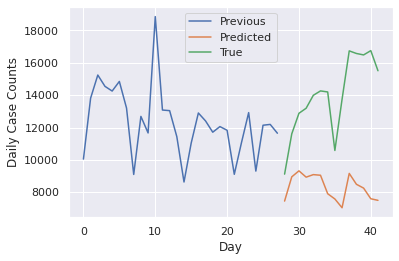

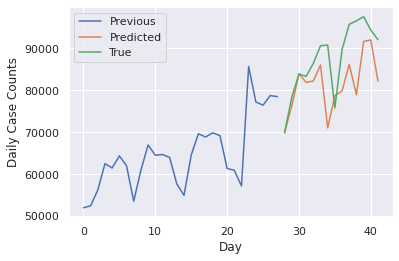

In [ ]:
# xtrain, ytrain, xtest, ytest = india
# samples, forecasts = np.vstack([xtrain, xtest]), np.vstack([ytrain, ytest])
# train_indices = np.random.randint(0,11,5)
# test_indices = [i for i in np.arange(10) if i not in train_indices]
# xtrain, ytrain = samples[train_indices,:,:], forecasts[train_indices]
# xtest, ytest = samples[test_indices], forecasts[test_indices]
# # model = NBeatsKeras.load("/content/meta_nbeats_trend_seasonality_epochs=500.h5")

# test_preds = model.predict([xtest[:,:,-1],xtest[:,:,:-1]]).squeeze()

# error = mean_absolute_error(ytest, test_preds)
# rmse = np.sqrt(np.square(test_preds - ytest).mean())
# # Reset the weights after getting the evaluation accuracies.
# r2 = r2_score(ytest, test_preds)

# print(f"Before R2 {r2} RMSE {rmse} MAE {error}")

# with tf.GradientTape() as tape:
#     # preds = tf.squeeze(model.models['forecast'](images))
#     preds = tf.squeeze(model([xtrain[:,:,-1],xtrain[:,:,:-1]]))
#     loss = keras.losses.mean_squared_error(ytrain, preds)
#     # loss = keras.losses.poisson(labels, preds)
#     # loss = negbinNLLLoss(labels, preds, theta)
# grads = tape.gradient(loss, model.trainable_weights)
# optimizer.apply_gradients(zip(grads, model.trainable_weights))


# test_preds = model.predict([xtest[:,:,-1],xtest[:,:,:-1]]).squeeze()

# error = mean_absolute_error(ytest, test_preds)
# rmse = np.sqrt(np.square(test_preds - ytest).mean())
# # Reset the weights after getting the evaluation accuracies.
# r2 = r2_score(ytest, test_preds)
# print(f"After R2 {r2} RMSE {rmse} MAE {error}")



for i in range(2):
    plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
    plt.tight_layout()
    plt.plot(np.arange(0,28), india[2][i,:,-1], label="Previous")
    plt.plot(np.arange(28,42), test_preds[i], label='Predicted')
    plt.plot(np.arange(28,42), india[3][i], label="True")
    plt.legend()
    plt.ylabel("Daily Case Counts")
    plt.xlabel("Day")
    plt.savefig(f"metaL_forecast_{i}.pdf")
    plt.show()


# plt.cla()

# plt.plot(np.arange(0,28), dataset[0][1,:,-1], label="Previous")
# plt.plot(np.arange(28,42), test_preds[1], label='Predicted')
# plt.plot(np.arange(28,42), dataset[1][1], label="True")
# plt.legend()
# plt.show()



In [ ]:
train_preds = model.predict([india[0][:,:,-1],india[0][:,:,:-1]])
train_preds.shape

(7, 14, 1)

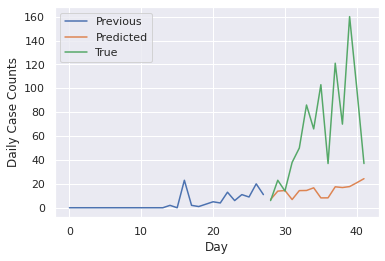

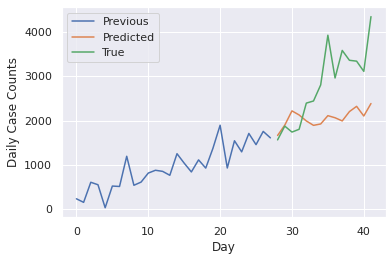

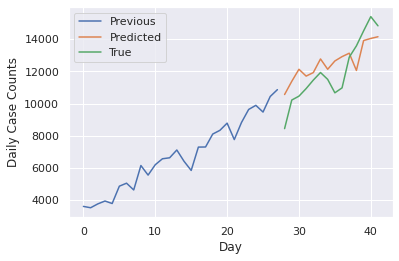

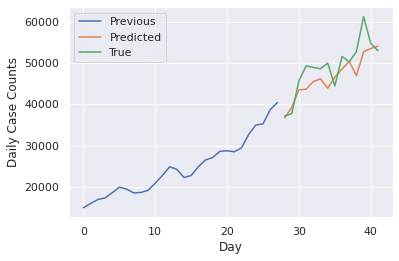

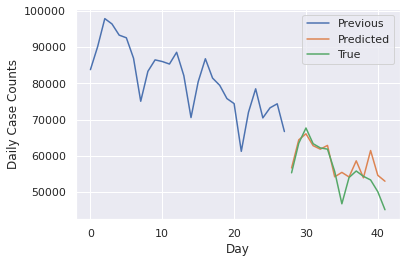

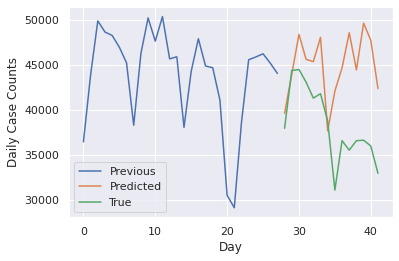

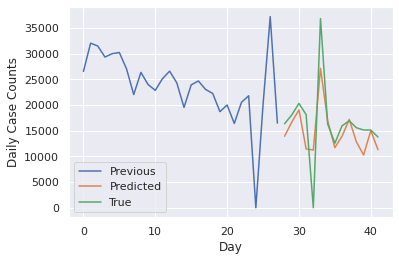

In [ ]:

for i in range(7):
    plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
    plt.tight_layout()
    plt.plot(np.arange(0,28), india[0][i,:,-1], label="Previous")
    plt.plot(np.arange(28,42), train_preds[i], label='Predicted')
    plt.plot(np.arange(28,42), india[1][i], label="True")
    plt.ylabel("Daily Case Counts")
    plt.xlabel("Day")
    plt.legend()
    
    plt.savefig(f"metaL_forecast_{i+2}.pdf")
    plt.show()

In [ ]:
 # print(test_images.tranpose(2,1,0))

def negbinNLLLoss(y_true, y_pred, theta):
    # y_true = tf.cast(y_true, tf.float32)
    eps = 1e-10
    # theta = tf.nn.softplus(theta)

    # y_pred *= scale_factor
    
    theta = 1.0/(theta+eps)

    t1 = -tf.math.lgamma(y_true+theta+eps) 
    t2 = tf.math.lgamma(theta+eps)
    t3 = tf.math.lgamma(y_true+1.0) 
    t4 = -(theta * (tf.math.log(theta+eps)))
    t5 = -(y_true * (tf.math.log(y_pred+eps)))
    t6 = (theta+y_true) * tf.math.log(theta+y_pred+eps)

    return tf.reduce_mean(t1+t2+t3+t4+t5+t6)



In [ ]:
from nbeats_keras.model import NBeatsNet as NBeatsKeras
num_samples, time_steps, input_dim, output_dim, exo_dim = 50_000, 28, 1, 14, 7

backend1 = NBeatsKeras(input_dim=input_dim,exo_dim=exo_dim,
    backcast_length=time_steps, forecast_length=output_dim,
    stack_types=(NBeatsKeras.TREND_BLOCK, NBeatsKeras.SEASONALITY_BLOCK),
    nb_blocks_per_stack=2, thetas_dim=(4, 4), share_weights_in_stack=True,
    hidden_layer_units=128
)
# loss = negbinLoss()
import keras
# Definition of the objective function and the optimizer.
backend1.compile()
optimizer = keras.optimizers.SGD(lr=0.001, clipnorm=1)
model2 = backend1

In [ ]:
# dset = [(),]
from tqdm import tqdm
train_losses, test_losses = [], []
trainE, testE = [], []
trainmape, testmape = [], []
for epoch in tqdm(range(150)):
    for images, labels in trset:
        with tf.GradientTape() as tape:
            preds = tf.squeeze(model2.models['forecast']([images[:,:,-1],images[:,:,:-1]]))
            loss = keras.losses.mean_squared_error(labels, preds)
        grads = tape.gradient(loss, model2.trainable_weights)
        optimizer.apply_gradients(zip(grads, model2.trainable_weights))
        train_losses.append(np.sqrt(mean_squared_error(labels,preds)))
        trainE.append(mean_absolute_error(labels, preds))
        trainmape.append(mape(labels, preds))

    if epoch % 5 == 0:
        iter = 0
        t1,t2,t3 = [], [], []
        for images, labels in teset:
            if iter == 0:
                preds1 = tf.squeeze(model2.models['forecast']([images[:,:,-1],images[:,:,:-1]]))
                t1.append(np.sqrt(mean_squared_error(labels,preds1)))
                t2.append(mean_absolute_error(labels, preds1))
                t3.append(mape(labels, preds1))
            else:
                preds2 = tf.squeeze(model2.models['forecast']([np.expand_dims(images[:,-1],0),np.expand_dims(images[:,:-1],0)]))
                t1.append(np.sqrt(mean_squared_error(labels,preds2)))
                t2.append(mean_absolute_error(labels, preds2))
                t3.append(mape(labels, preds2))

            iter += 1

        test_losses.append(np.mean(t1))
        testE.append(np.mean(t2))
        testmape.append(np.mean(t3))

        # print(f"Logging",{'Iteration': epoch,
        #     'training error': train_losses[-1],
        #     'testing error': test_losses[-1], 
        #     # 'training R2': r2s[0],
        #     # 'testing R2': r2s[1],
        #     'training MAE':trainE[-1],
        #     'testing MAE':testE[-1],
        #     'training MAPE':trainmape[-1],
        #     'testing MAPE':testmape[-1]})

        wandb.log({'Iteration': epoch,
            'training error': train_losses[-1],
            'testing error': test_losses[-1], 
            # 'training R2': r2s[0],
            # 'testing R2': r2s[1],
            'training MAE':trainE[-1],
            'testing MAE':testE[-1],
            'training MAPE':trainmape[-1],
            'testing MAPE':testmape[-1]})


100%|██████████| 150/150 [00:08<00:00, 17.93it/s]


In [ ]:
model2.save("nbeats_trend_seasonality_epochs_univariate_stringency_mobility=150.h5")

rmse 8018.865318563963, mae 5755.169712611607, mape 16.9030818090375


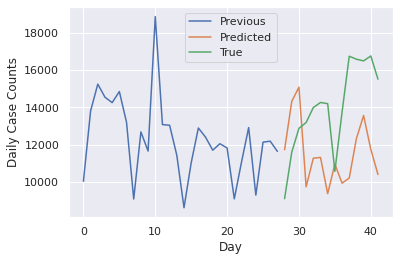

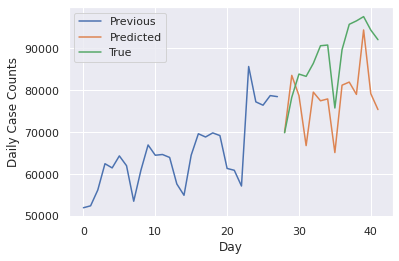

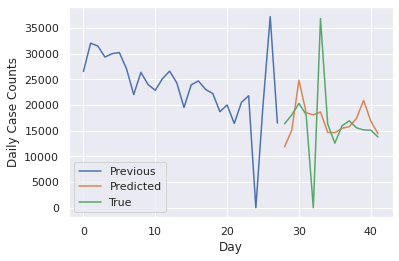

In [ ]:
iter = 0
t1, t2, t3 = [], [], []
for images, labels in teset:
    if iter == 0:
        preds1 = tf.squeeze(model2.models['forecast']([images[:,:,-1],images[:,:,:-1]]))
        t1.append(np.sqrt(mean_squared_error(labels,preds1)))
        t2.append(mean_absolute_error(labels, preds1))
        t3.append(mape(labels, preds1))
    else:
        preds2 = tf.squeeze(model2.models['forecast']([np.expand_dims(images[:,-1],0),np.expand_dims(images[:,:-1],0)]))
        t1.append(np.sqrt(mean_squared_error(labels,preds2)))
        t2.append(mean_absolute_error(labels, preds2))
        t3.append(mape(labels, preds2))
    iter += 1

print(f"rmse {np.mean(t1)}, mae {np.mean(t2)}, mape {np.mean(t3)}")

for i in range(2):
    plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
    plt.tight_layout()
    plt.plot(np.arange(0,28), teset[0][0][i,:,-1], label="Previous")
    plt.plot(np.arange(28,42), preds1[i], label='Predicted')
    plt.plot(np.arange(28,42), teset[0][1][i], label="True")
    plt.legend()
    plt.ylabel("Daily Case Counts")
    plt.xlabel("Day")
    plt.savefig(f"nbeats_forecast_{i}.pdf")
    plt.show()

# for i in range(1):
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.tight_layout()
plt.plot(np.arange(0,28), teset[1][0][:,-1], label="Previous")
plt.plot(np.arange(28,42), preds2, label='Predicted')
plt.plot(np.arange(28,42), teset[1][1], label="True")
plt.legend()
plt.ylabel("Daily Case Counts")
plt.xlabel("Day")
plt.savefig(f"nbeats_forecast_2.pdf")
plt.show()



In [ ]:
wandb.init()
# labels.shape, preds.shape

Iteration,995
training error,979.68841
testing error,6535.36724
training MAE,694.62043
testing MAE,4841.34867
training MAPE,18.26042
testing MAPE,17.42342
_runtime,259
_timestamp,1619778896
_step,399


Iteration,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇█▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
training error,████████████████████▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
testing error,████████████████████▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training MAE,████████████████████▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
testing MAE,████████████████████▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training MAPE,████████████████████▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
testing MAPE,████████████████████▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [ ]:
trset = [(india[0][:-1,:,:],india[1][:-1,:])]
teset = [(india[2],india[3]),(india[0][-1,:,:],india[1][-1,:])]

In [93]:
india[0].shape

(7, 28, 1)

In [ ]:
import statsmodels
from statsmodels.tsa.holtwinters import Holt

In [ ]:
smoothener = Holt(df[df['District']=='Mumbai']['new cases'].values)

In [ ]:
smoothener_i = smoothener.fit()

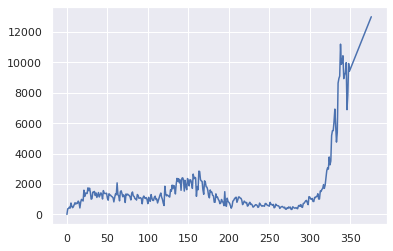

In [ ]:
# plt.plot(smoothener.predict(df[df['District']=='Mumbai']['new cases'].values))
# plt.plot()
a = df[df['District']=='Mumbai']['new cases'].values.tolist()
a.extend(smoothener_i.forecast(28))
plt.plot(a)
# plt.plot(smoothener_i.forecast(14)))

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt


In [ ]:
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', lags="auto", )
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [ ]:
adf_test(df[df['District']=='Mumbai']['new cases'].values)

Results of Dickey-Fuller Test:
Test Statistic                  -3.192903
p-value                          0.020399
#Lags Used                      15.000000
Number of Observations Used    333.000000
Critical Value (1%)             -3.450141
Critical Value (5%)             -2.870259
Critical Value (10%)            -2.571415
dtype: float64


In [ ]:
kpss_test(df[df['District']=='Mumbai']['new cases'].values)

Results of KPSS Test:
Test Statistic            0.518295
p-value                   0.037546
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


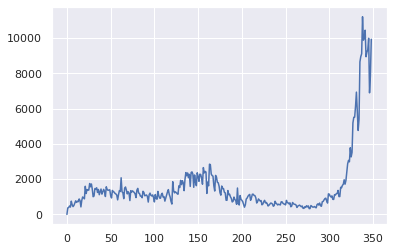

In [ ]:
plt.plot(df[df['District']=='Mumbai']['new cases'].values)